In [1]:
#full pipeline: hdf5 -> stream properties

#1. import dependencies
#2. import files
#3. rotate objects
#4. filter
#5. fit potentials
#6. solve actions
#--
#7. cluster streams
#8. stream properties

In [2]:
#1. import dependencies
import h5py
import matplotlib.pyplot as plt
import numpy as np
import numpy
import glob

from sklearn import metrics
from sklearn.cluster import DBSCAN

import galpy
from galpy.actionAngle import estimateDeltaStaeckel
from galpy.actionAngle import actionAngleStaeckel
from galpy.actionAngle import actionAngleIsochrone
import galpy.potential
from galpy.potential import IsochronePotential
from galpy.potential import MWPotential2014 

from astropy import units

import agama

import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import DBSCAN, HDBSCAN

  Referenced from: <85E686CF-7C28-3AEF-BBDD-9BA46BC63A62> /Users/benjaminhanf/opt/anaconda3/envs/pomthesis2/lib/python3.12/site-packages/libgalpy.cpython-312-darwin.so
  Reason: tried: '/Users/benjaminhanf/opt/anaconda3/envs/pomthesis2/lib/python3.12/site-packages/../../libgsl.25.dylib' (no such file), '/Users/benjaminhanf/opt/anaconda3/envs/pomthesis2/lib/python3.12/site-packages/../../libgsl.25.dylib' (no such file), '/Users/benjaminhanf/opt/anaconda3/envs/pomthesis2/lib/python3.12/lib-dynload/../../libgsl.25.dylib' (no such file), '/Users/benjaminhanf/opt/anaconda3/envs/pomthesis2/bin/../lib/libgsl.25.dylib' (no such file), '/usr/local/lib/libgsl.25.dylib' (no such file), '/usr/lib/libgsl.25.dylib' (no such file, not in dyld cache)'


In [3]:
#2. import files, should be named '...obj..._25.hdf5' for example
files={}
for filepath in glob.iglob('./historic_streams/z0_objects/*'):
    files[filepath[len(filepath)-7:][:-5]]=h5py.File(filepath)
    print(filepath)
files

# for obj in files:
#     plt.scatter(files[obj]['stellar_x'][::20], files[obj]['stellar_y'][::20], s=1, color='black')
#     plt.show()

./historic_streams/z0_objects/particles_within_Rvir_object_25.hdf5
./historic_streams/z0_objects/particles_within_Rvir_object_28.hdf5
./historic_streams/z0_objects/particles_within_Rvir_object_24.hdf5


{'25': <HDF5 file "particles_within_Rvir_object_25.hdf5" (mode r)>,
 '28': <HDF5 file "particles_within_Rvir_object_28.hdf5" (mode r)>,
 '24': <HDF5 file "particles_within_Rvir_object_24.hdf5" (mode r)>}

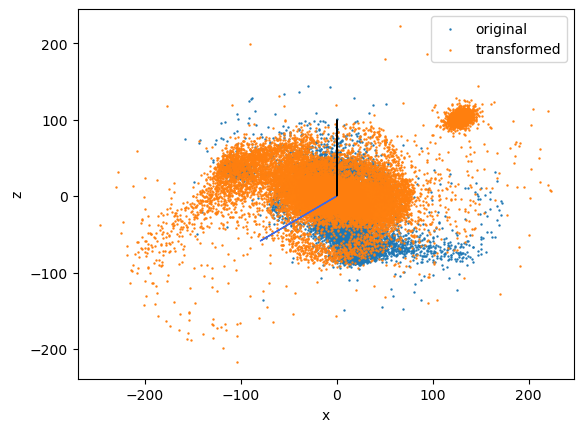

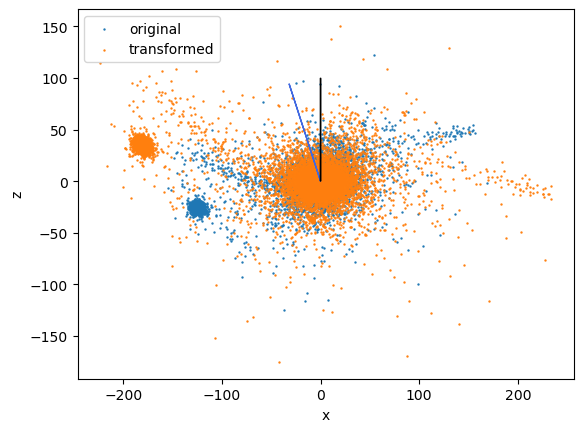

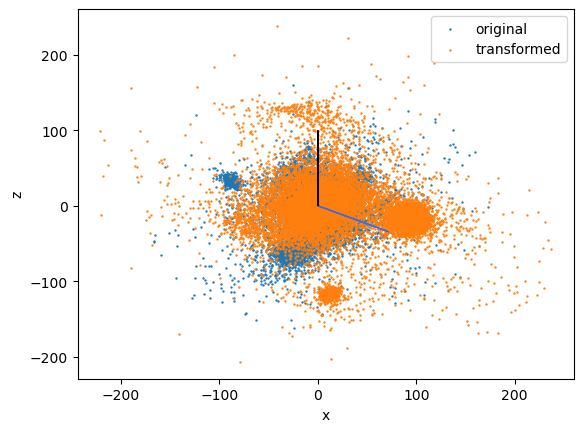

In [4]:
#3. rotate objects

#rotate star plane to align with xy
def ang_mom_vec(pos, mass, vel):
    """
    Returns the angular momentum vector of the particles provided.
    Units are [mass]*[dist]*[vel].
    """
    angmom = (mass.reshape((len(mass), 1)) *
              np.cross(pos, vel)).sum(axis=0).view(np.ndarray)
    return angmom

def calc_faceon_matrix(angmom_vec, up=[0.0, 1.0, 0.0]):
    """
    Returns the 'face on' matrix required to rotate the cartesian coordinates so that the z axis is 
    aligned with the angular momentum vector
    """
    vec_in = np.asarray(angmom_vec)
    vec_in = vec_in / np.sum(vec_in ** 2).sum() ** 0.5
    vec_p1 = np.cross(up, vec_in)
    vec_p1 = vec_p1 / np.sum(vec_p1 ** 2).sum() ** 0.5
    vec_p2 = np.cross(vec_in, vec_p1)

    matr = np.concatenate((vec_p1, vec_p2, vec_in)).reshape((3, 3))

    return matr

file_pos, file_vel, faceon_matrices, L_stars_dict, transformed_pos, transformed_vel = {}, {}, {}, {}, {}, {}

for file in files:
    
    f = files[file]

    threed_pos = np.stack((np.array(f['stellar_x']),
                        np.array(f['stellar_y']),
                        np.array(f['stellar_z'])), axis=1)

    threed_vel = np.stack((np.array(f['stellar_vx']),
                        np.array(f['stellar_vy']),
                        np.array(f['stellar_vz'])), axis=1)
    
    file_pos[file]=threed_pos
    file_vel[file]=threed_vel

    L_stars_dict[file] = ang_mom_vec(file_pos[file], np.array(files[file]['stellar_mass']), file_vel[file])

    faceon_matrices[file] = calc_faceon_matrix(L_stars_dict[file], up=[0.0, 1.0, 0.0])
    
    # print(faceon_matrices[file])
    
    h=0.7
    
    transformed_pos[file] = np.matmul(faceon_matrices[file], file_pos[file].T) / h
    transformed_vel[file] = np.matmul(faceon_matrices[file], file_vel[file].T) / h
    
    # print(transformed_pos[file], transformed_vel[file])
    
    N=5
    size = 0.5
    plt.scatter(file_pos[file].T[0][::N], file_pos[file].T[2][::N], s = size, label = 'original')
    plt.scatter(transformed_pos[file][0][::N], transformed_pos[file][2][::N], s= size, label = 'transformed')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('z')
    
    plt.arrow(0,0,100 * L_stars_dict[file][0] / np.linalg.norm(L_stars_dict[file]), 100 * L_stars_dict[file][2] / np.linalg.norm(L_stars_dict[file]), color = 'royalblue') #calculated for entire object
    # plt.arrow(0,0,mask_L_stars_list[0], mask_L_stars_list[2], color = 'dimgrey') #calculated for mask
    # plt.arrow(0,0,0, 100 * np.matmul(faceon_matrices[file],(L_stars_dict[file] / np.linalg.norm(L_stars_dict[file])).T), color = 'black') #aligned (untested)
    plt.arrow(0,0,0, 100 * 1, color = 'black') #aligned (untested)

    plt.show()

In [5]:
files['24']['Rvir'][()] / h

256.9428571428572

<>:59: SyntaxWarning: invalid escape sequence '\s'

<>:59: SyntaxWarning: invalid escape sequence '\s'

/var/folders/cs/cpwlb8215w7_8nfgdjnp7y400000gn/T/ipykernel_34634/1563369631.py:59: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('dm$_\star$/dr [$M_\odot$ / kpc]', fontsize=font_size)

r75 for object 25 = 9.84564133222082
r75 for object 28 = 7.591837157279141
r75 for object 24 = 21.544134607870195


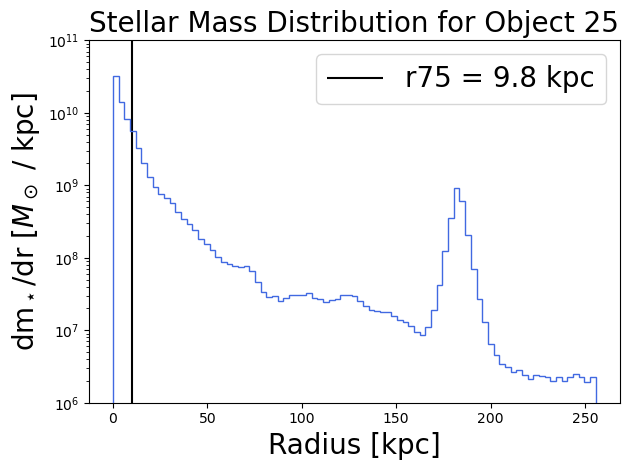

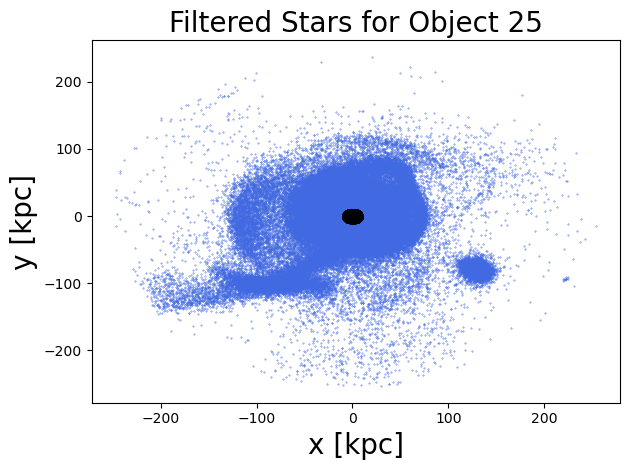

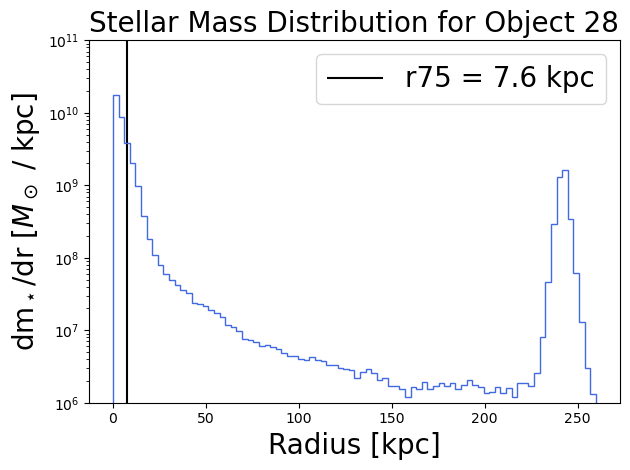

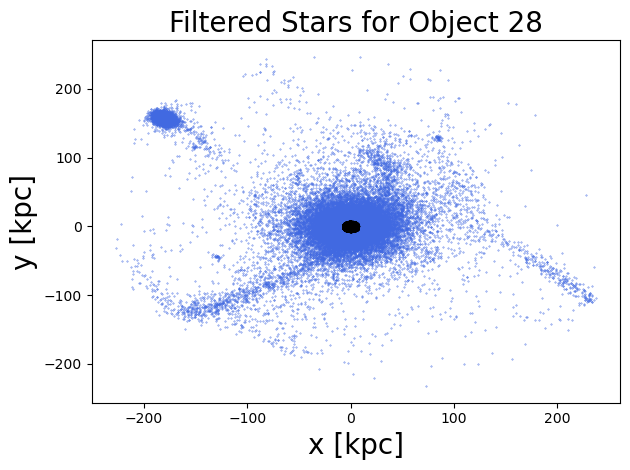

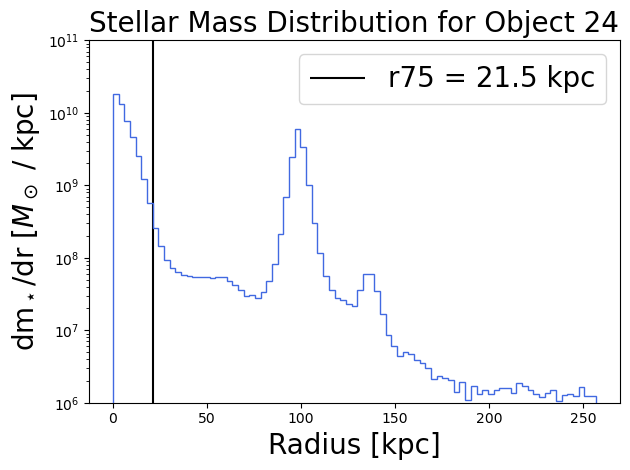

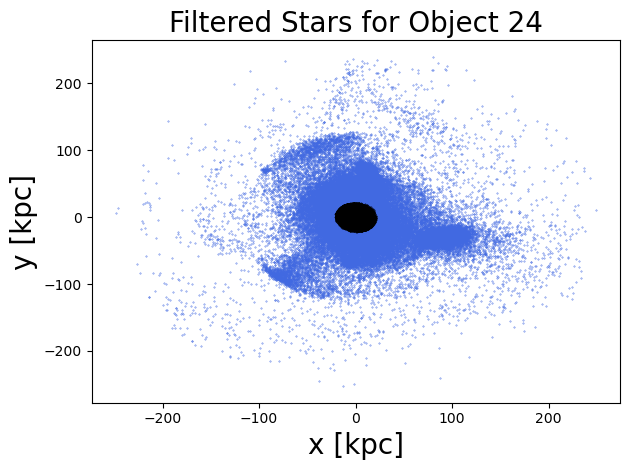

In [10]:
#4. filter

def distance_from(xcoord, ycoord, zcoord, objectx, objecty, objectz):
    dist_list = np.sqrt((xcoord - objectx)**2 + (ycoord - objecty)**2 + (zcoord - objectz)**2)
    return dist_list

r_dict = {}
pos_mask = {}
#25, 28, 24
# max_radii = [125, 150, 120]

# calculate rN
min_radii = []
N = 0.75
font_size = 20
font_size2 = 20

for file in files:
    
    r_dict[file] = distance_from(np.zeros(len(files[file]['stellar_x'])), np.zeros(len(files[file]['stellar_x'])), np.zeros(len(files[file]['stellar_x'])), 
                                 files[file]['stellar_x'][:]/h, files[file]['stellar_y'][:]/h, files[file]['stellar_z'][:]/h)
    
    radii = r_dict[file] 
    masses = files[file]['stellar_mass'][:] 

    def calculate_rN(radii, N=N, masses=None):
        sorted_indices = np.argsort(radii)
        sorted_radii = radii[sorted_indices]
        
        if masses is None:
            cumulative_fraction = np.linspace(1 / len(radii), 1.0, len(radii))
        else:
            sorted_masses = masses[sorted_indices]
            cumulative_mass = np.cumsum(sorted_masses)
            total_mass = cumulative_mass[-1]
            cumulative_fraction = cumulative_mass / total_mass

        rN = np.interp(N, cumulative_fraction, sorted_radii)
        return rN

    rN = calculate_rN(radii, masses=masses)
    print(f'r{int(N*100)} for object {file} = {rN}')
    
    min_radii.append(rN)

max_radii = [files['25']['Rvir'][()] / h,files['28']['Rvir'][()] / h,files['24']['Rvir'][()] / h]
# min_radii = [15,15,15]

for j,file in enumerate(files):

    pos_mask[file] = (min_radii[j] <= r_dict[file]) & (r_dict[file] <= max_radii[j])
    
    # plt.vlines(max_radii[j], 10**7, 10**10, color='black')
    plt.vlines(min_radii[j], 10**4, 10**12, color='black', label = f'r{int(N*100)} = {round(min_radii[j],1)} kpc')

    g=3
    plt.hist(r_dict[file], cumulative=False, log=True, weights=files[file]['stellar_mass'][:] * 10**10,histtype='step', color='royalblue', bins= int(max_radii[j] / g))
    plt.xlabel('Radius [kpc]', fontsize=font_size)
    plt.ylabel('dm$_\star$/dr [$M_\odot$ / kpc]', fontsize=font_size)
    plt.ylim(10**6, 10**11)
    plt.title(f'Stellar Mass Distribution for Object {file}', fontsize=font_size2)
    plt.legend(fontsize=font_size)
    plt.tight_layout()
    plt.savefig(f'/Users/benjaminhanf/Desktop/pomona_s25/thesis/prelim_thesis_plots/draft1_stellar_distribution_{file}.jpg', dpi=300)

    plt.show()
    
    mask = pos_mask[file]
    antimask = ~pos_mask[file]
        
    fig, ax = plt.subplots()
    plt.scatter(transformed_pos[file][0][mask],transformed_pos[file][1][mask], s=.1, color='royalblue')
    plt.scatter(transformed_pos[file][0][antimask],transformed_pos[file][1][antimask], s=.1, color='black')
    # circle1 = plt.Circle((0, 0), max_radii[j], color='black', fill=False)
    ax.set_xlabel('x [kpc]', fontsize=font_size)
    ax.set_ylabel('y [kpc]', fontsize=font_size)
    # ax.add_patch(circle1)
    plt.title(f'Filtered Stars for Object {file}', fontsize=font_size2)
    plt.tight_layout()    
    # fig, ax = plt.subplots()
    # plt.scatter(transformed_pos[file][0][mask],transformed_pos[file][2][mask], s=.1, color='royalblue')
    # plt.scatter(transformed_pos[file][0][antimask],transformed_pos[file][2][antimask], s=.1, color='black')
    # circle1 = plt.Circle((0, 0), max_radii[j], color='black', fill=False)
    # ax.set_xlabel('x')
    # ax.set_ylabel('z')
    # ax.add_patch(circle1)
    # plt.title(file)
    
    plt.savefig(f'/Users/benjaminhanf/Desktop/pomona_s25/thesis/prelim_thesis_plots/draft1_filtered_stars_{file}.jpg', dpi=300)
    
    plt.show()

# x,y,z = x[mask],y[mask],z[mask]

In [13]:
agama.setUnits(length=1, velocity=1, mass=1e10)
print("units: %s" % agama.getUnits() + ", G=%g" % agama.G)

/Users/benjaminhanf/opt/anaconda3/envs/pomthesis2/lib/python3.12/site-packages/agama/py/pygama.py:21: RuntimeWarning: setUnits() called after creating instances of Potential and other classes may lead to incorrect scaling of input/output data in their methods
  return _setUnits(**args)  # call the setUnits(...) function from the C++ extension module

units: {'length': <Quantity 1. kpc>, 'velocity': <Quantity 1. km / s>, 'time': <Quantity 977.79222168 Myr>, 'mass': <Quantity 1.e+10 solMass>}, G=43009.2


In [ ]:
#5. fit potentials

def to_v_rho(xcoord, ycoord, zcoord, objectx, objecty, objectz, objectvx, objectvy, objectvz):
    v_rho_list = np.zeros(len(objectx))
    for i in range(len(objectx)):
    
        rho = [(-xcoord + objectx[i]), (-ycoord + objecty[i]), (0)]
        
        vel_vector = [(objectvx[i]), (objectvy[i]), (objectvz[i])]
        
        normalized_rho = rho / np.linalg.norm(rho)
        
        v_rho = np.dot(vel_vector, normalized_rho)

        v_rho_list[i] = v_rho
        
    return v_rho_list

#reproject velocity onto galactic plane so that vr, vz, vt make basis for velocity space
def new_to_tang(xcoord, ycoord, zcoord, objectx, objecty, objectz, objectvx, objectvy, objectvz):
    tang_list = np.zeros(len(objectx))
    for i in range(len(objectx)):
        rho = [(-xcoord + objectx[i]), (-ycoord + objecty[i]), (0)]
        
        vel_vector = [(objectvx[i]), (objectvy[i]), (objectvz[i])]
        
        normalized_rho = rho / np.linalg.norm(rho)
        
        v_rho = np.dot(vel_vector, normalized_rho)

        tang_vel = np.array(vel_vector - (v_rho * normalized_rho) - np.array([0,0,objectvz[i]])) #atan2
        
        # tang_vel_def2 = [vel_vector[0] - v_rho * normalized_rho[0], vel_vector[1] - v_rho * normalized_rho[1], 0]
                
        sign = 1
        
        ccw = np.cross([0,0,1], normalized_rho)
        
        sign = np.dot(tang_vel / np.linalg.norm(tang_vel), ccw)
        
        tang_list[i] = sign * np.linalg.norm(tang_vel)
    return tang_list

def to_rho(x,y):
    rho_list = np.zeros(len(x))
    for i in range(len(x)):
        rho = (x[i]**2 + y[i]**2)**0.5
        rho_list[i] = rho
    return rho_list

#fit 1- agama
agama.setUnits(length=1, velocity=1, mass=1e10)
print("units: %s" % agama.getUnits() + ", G=%g" % agama.G)


pot_multipole_dict, pot_cylspline_dict = {}, {}
v_rho_dict, vt_dict, rho_dict = {}, {}, {}

for file in files:

    f = files[file]
    x=transformed_pos[file][0]
    y=transformed_pos[file][1]
    z=transformed_pos[file][2]
    
    vx=transformed_vel[file][0]
    vy=transformed_vel[file][1]
    vz=transformed_vel[file][2]
    
    faceon_matrix = faceon_matrices[file]
    
    v_rho_dict[file] = to_v_rho(0,0,0,x,y,z,vx,vy,vz)
    vt_dict[file] = new_to_tang(0,0,0,x,y,z,vx,vy,vz)
    rho_dict[file] = to_rho(x,y)

    plt.scatter(f['gas_rho'], f['gas_u'], s=0.0001)
    plt.yscale('log')
    plt.xscale('log')
    
    plt.hlines(10**3, 1e-8, 1, color='red')
    
    plt.show()


    #fit dm + hot gas using spherical multipole
    h=0.7

    #calculate (mask rotated) dm positions
    dm_threed_pos = np.stack((f['dm_x'],
                        f['dm_y'],
                        f['dm_z']), axis=1)

    dm_transformed_coords = np.matmul(faceon_matrix, dm_threed_pos.T / h)
    dm_pos = dm_transformed_coords

    #dm mass array
    dm_mass = np.array(f['dm_mass']) / h

    gas_temp = f['gas_u']
    tsel = (np.log10(gas_temp) > 3)

    gas_threed_pos = np.stack((f['gas_x'],
                        f['gas_y'],
                        f['gas_z']), axis=1)

    hot_gas_pos = np.matmul(faceon_matrix, ((gas_threed_pos)[tsel]).T)
    hot_gas_mass = np.array((f['gas_mass'])[tsel] / h)

    pos_multi = np.hstack((dm_pos, hot_gas_pos)).T
    m_multi = np.hstack((dm_mass, hot_gas_mass))

    pot_multipole_dict[file] = agama.Potential(type='Multipole', particles=(pos_multi, m_multi), symmetry='Axisymmetric', lmax=4, rmin=0.1)
    
    tsel = (np.log10(gas_temp) < 3)
    cold_gas_pos = np.matmul(faceon_matrix, ((gas_threed_pos)[tsel]).T)
    cold_gas_mass = np.array((f['gas_mass'])[tsel] / h)
    
    stars_threed_pos = np.stack((f['stellar_x'],
                        f['stellar_y'],
                        f['stellar_z']), axis=1)

    star_pos = np.matmul(faceon_matrix, ((stars_threed_pos)).T)
    star_mass = np.array(f['stellar_mass']) / h

    pos_cylspline = np.hstack((star_pos, cold_gas_pos)).T
    m_cylspline = np.hstack((star_mass, cold_gas_mass))

    print(pos_cylspline.shape, m_cylspline.shape)

    pot_cylspline_dict[file] = agama.Potential(type='CylSpline', particles=(pos_cylspline, m_cylspline), symmetry='Axisymmetric', mmax=4, rmin=0.1)
    
#42m47s, 3 objects

#calculate temp from u and 'gas_ne', then make cuts accordingly

units: {'length': <Quantity 1. kpc>, 'velocity': <Quantity 1. km / s>, 'time': <Quantity 977.79222168 Myr>, 'mass': <Quantity 1.e+10 solMass>}, G=43009.2


<>:39: SyntaxWarning: invalid escape sequence '\o'

<>:39: SyntaxWarning: invalid escape sequence '\o'

/var/folders/cs/cpwlb8215w7_8nfgdjnp7y400000gn/T/ipykernel_34634/3271925591.py:39: SyntaxWarning: invalid escape sequence '\o'
  ax[1].set_title(r'edge-on surface density, obj ' + str(file) +  ' [$M_\odot/\mathsf{kpc}^2$]')



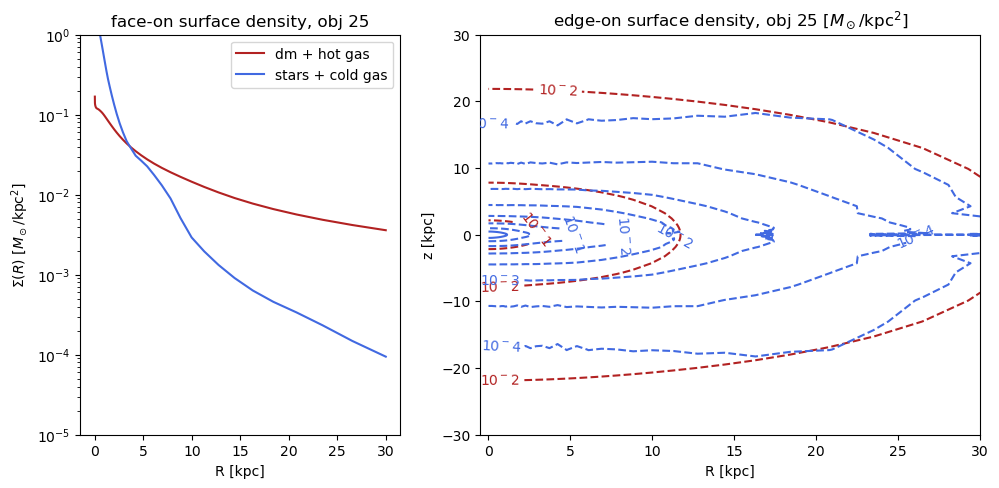

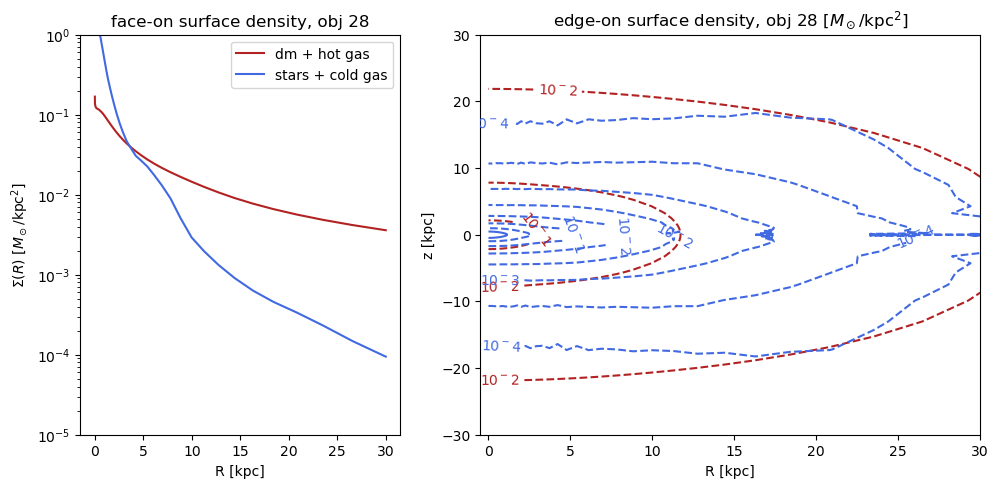

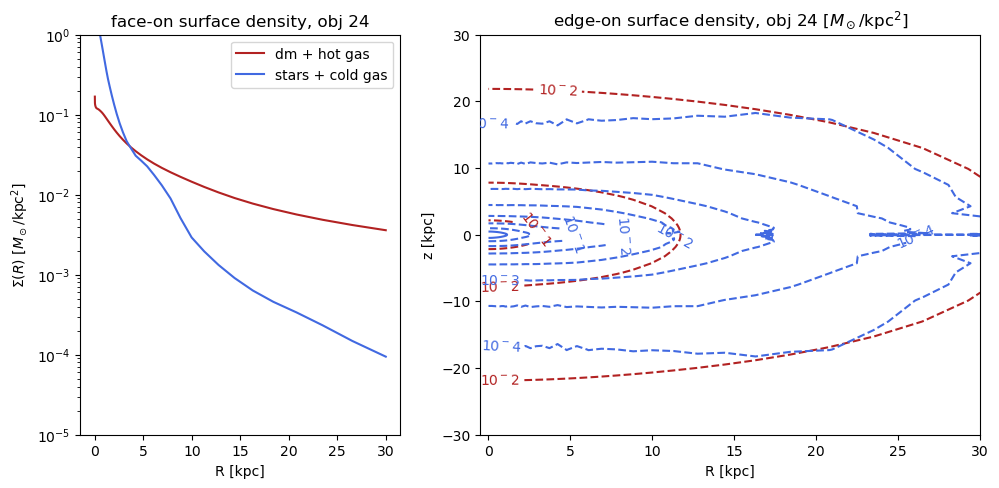

In [15]:
#plot potentials

for file in files:
    
    # pot_total = agama.Potential(pot_multipole_dict[file], pot_cylspline_dict[file])
    pot_total = agama.Potential("/Users/benjaminhanf/Desktop/pomona_s25/thesis/pipeline/to_green_planet/25/25/pot_total_25")
    pot_names = ['dm + hot gas', 'stars + cold gas']

    solarRadius = 8.0  # kpc

    gridR = agama.nonuniformGrid(50, 0.01, 30.0)
    gridR00 = numpy.column_stack((gridR, gridR*0, gridR*0))    # for the radial profile at z=0
    gridz   = agama.symmetricGrid(50, 0.01, 30)
    gridR0z = numpy.column_stack((gridz*0 + solarRadius, gridz*0, gridz))  # for the vertical profile at solar radius

    grid2R, grid2z = numpy.meshgrid(gridR, gridz)  # two 2d arrays of shape (len(gridR), len(gridz))
    gridRz = numpy.column_stack((grid2R.reshape(-1), grid2z.reshape(-1)))  # array of shape (len(gridR)*len(gridz), 2)
    gridR0 = numpy.column_stack((gridR, gridR*0))  # array of shape (len(gridR), 2)  for the 1d profile

    plt.figure(figsize=(10,5))
    ax=[plt.axes([0.08,0.1,0.32,0.8]), plt.axes([0.48,0.1,0.5,0.8])]
    for i in range(len(pot_total)):
        # face-on, 1d profile
        ax[0].plot(gridR, pot_total[i].projectedDensity(gridR0, beta=0), label=pot_names[i], c=['firebrick', 'royalblue'][i])
        # edge-on, 2d contour plot
        Sigma = pot_total[i].projectedDensity(gridRz, beta=numpy.pi/2).reshape(grid2R.shape)
        ax[1].clabel(ax[1].contour(grid2R, grid2z, numpy.log10(Sigma), levels=numpy.linspace(-4.1, 0, 8),
            colors=['firebrick', 'royalblue'][i]), fmt='$10^%.0f$')
    
    ax[0].set_xlabel('R [kpc]')
    ax[0].set_ylabel(r'$\Sigma(R)$ [$M_\odot/\mathsf{kpc}^2$]')
    ax[0].set_title('face-on surface density, obj '  + str(file))
    ax[0].set_yscale('log')
    ax[0].set_ylim(1e-5,1e0)
    ax[0].legend(loc='upper right')
    ax[1].set_xlim(-0.5, 30)
    ax[1].set_xlabel('R [kpc]')
    ax[1].set_ylabel('z [kpc]')
    ax[1].set_title(r'edge-on surface density, obj ' + str(file) +  ' [$M_\odot/\mathsf{kpc}^2$]')
    None

    plt.savefig('./aligned_surface_density_light_' + str(file) + '.jpg', dpi = 300)
    
    plt.show()

    plt.style.use('default')

In [172]:
pot_total_dict = {}
for file in files:  
    pot_total_dict[file] = agama.Potential(pot_multipole_dict[file], pot_cylspline_dict[file])
    # pot_total_dict[file].save("./pot_total_" + str(file))

pot_total_dict['24']

CompositePotential{ Multipole, CylSpline } (symmetry: Axisymmetric)

Vcirc at 8 kpc = 286.961 km/s, Vescape = 564.5 km/s
Vcirc at 8 kpc = 236.689 km/s, Vescape = 524.62 km/s
Vcirc at 8 kpc = 244.682 km/s, Vescape = 535.987 km/s


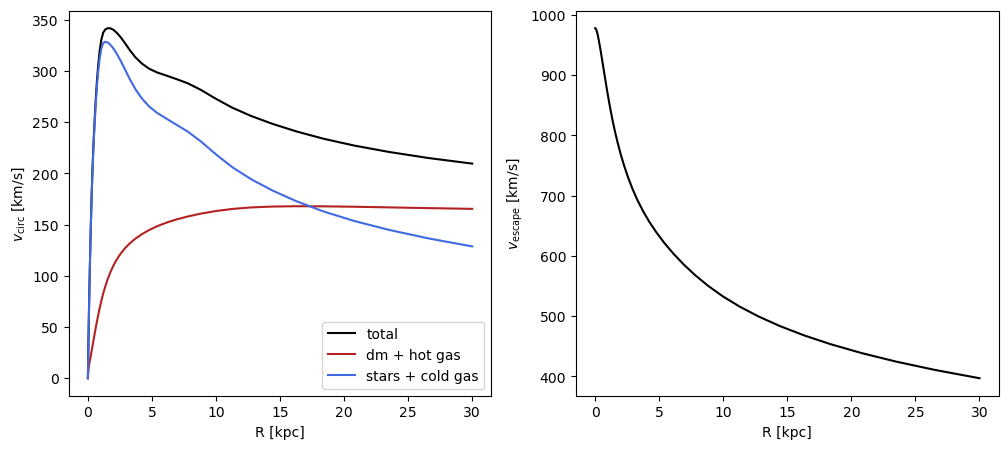

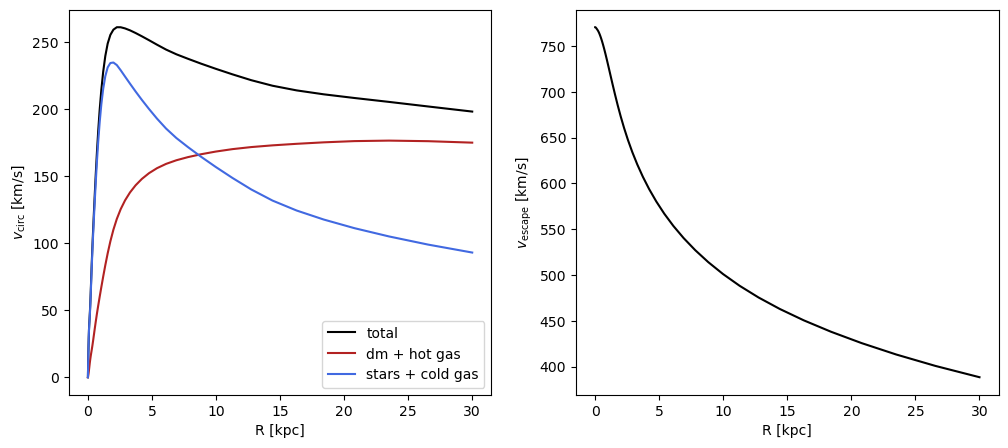

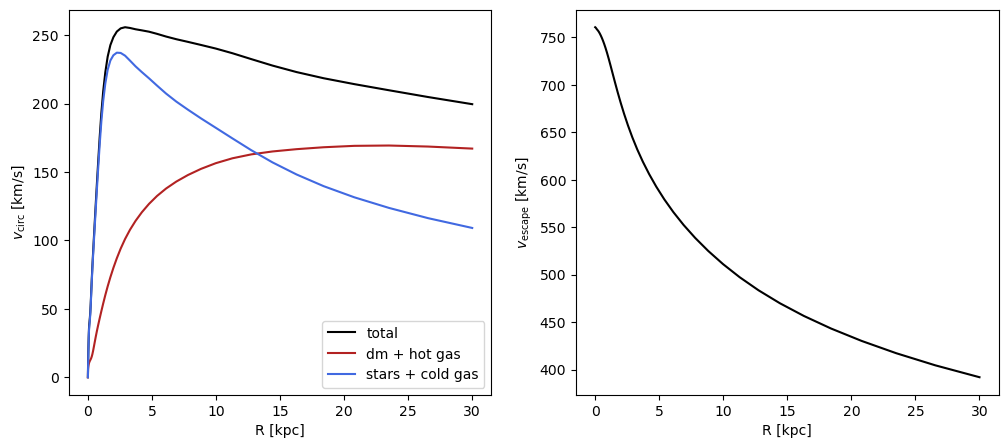

In [173]:
for file in files:
    pot_total = pot_total_dict[file]
    pot_names = ['dm + hot gas', 'stars + cold gas']

    def scalarize(x):
        return x if len(x)>1 else x[0]

    def v_escape(pot, r):
        return scalarize((-pot.potential(np.column_stack((r, r*0, r*0))) * 2) ** 0.5)

    def v_circ(pot, r):
        return scalarize((-r * pot.force(np.column_stack((r, r*0, r*0)))[:,0]) ** 0.5)

    gridR = agama.nonuniformGrid(50, 0.01, 30.0)
    ax=plt.subplots(1, 2, figsize=(12,5))[1]
    ax[0].plot(gridR, v_circ(pot_total, gridR), label='total', color='k')
    for i in range(len(pot_total)):
        ax[0].plot(gridR, v_circ(pot_total[i], gridR), label=pot_names[i], color=['firebrick', 'royalblue', 'g'][i])

    ax[0].set_xlabel('R [kpc]')
    ax[0].set_ylabel(r'$v_\mathsf{circ}$ [km/s]')
    ax[0].legend(loc='lower right')

    ax[1].plot(gridR, v_escape(pot_total, gridR), c = 'black')
    ax[1].set_xlabel('R [kpc]')
    ax[1].set_ylabel(r'$v_\mathsf{escape}$ [km/s]')
    print('Vcirc at 8 kpc = %g km/s, Vescape = %g km/s' % (v_circ(pot_total, 8.0), v_escape(pot_total, 8.0)))

    plt.savefig('./v_circ_+v_esc_vs_R_' + str(file) + '.jpg', dpi = 300)

In [ ]:
#staeckle approximation for actions

actions_dict = {}

for file in files:
    
    x=transformed_pos[file][0][pos_mask[file]]
    y=transformed_pos[file][1][pos_mask[file]]
    z=transformed_pos[file][2][pos_mask[file]]

    vx = transformed_vel[file][0][pos_mask[file]]
    vy = transformed_vel[file][1][pos_mask[file]]
    vz = transformed_vel[file][2][pos_mask[file]]
    
    rho=rho_dict[file]
    v_rho=rho_dict[file]
    vt=vt_dict[file]
    
    potential = agama.GalpyPotential(pot_total_dict[file])

    h=0.7
    jr,jp,jz,unbound_mask = np.zeros(len(x)), np.zeros(len(x)), np.zeros(len(x)), np.zeros(len(x))

    n=1

    for i in range(len(x))[::n]:
        delt = estimateDeltaStaeckel(potential,rho[i],z[i])
        # print(delt)
        aAS= actionAngleStaeckel(pot=potential,delta=delt,c=True, fixed_quad=True) #c=True is the default
        try:
            jr[i],jp[i],jz[i] = aAS(rho[i]*units.kpc, v_rho[i]*units.km/units.s, vt[i]*units.km/units.s, z[i]*units.kpc, vz[i]*units.km/units.s)
            # print(jr[i])
            if jr[i] > 10**5:
                unbound_mask[i] = 1
                print(sum(unbound_mask))
                print(jr[i], jp[i],jz[i])
                # jr[i], jp[i],jz[i] = 0, 0, 0
                # print(jr[i])
        except:
            unbound_mask[i] = 1
            # print(i, r[i]*units.kpc / h, vr[i]*units.km/units.s, vt[i]*units.km/units.s, z[i]*units.kpc / h, vz[i]*units.km/units.s, 'unbound')
    
    actions_dict[file] = [jr, jp, jz]
    
    print(n * sum(unbound_mask) / len(x))
    
# Save
with open('./actions_dict.pkl', 'wb') as f:
    pickle.dump(actions_dict, f)

# Load
with open('./actions_dict.pkl', 'rb') as f:
    loaded_actions_dict = pickle.load(f)

#n=100 -> 1:24
#n=10 -> 13:36 ?
"""
0.010628242559179987
0.0006213688756330195
0.3462906145294427
"""
#obj 24 is 35% unbound ...
        

/var/folders/cs/cpwlb8215w7_8nfgdjnp7y400000gn/T/ipykernel_18468/1152150924.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  jr[i],jp[i],jz[i] = aAS(rho[i]*units.kpc, v_rho[i]*units.km/units.s, vt[i]*units.km/units.s, z[i]*units.kpc, vz[i]*units.km/units.s)

/Users/benjaminhanf/opt/anaconda3/envs/pomthesis2/lib/python3.12/site-packages/galpy/actionAngle/actionAngleStaeckel.py:1574: RuntimeWarning: invalid value encountered in sqrt
  return numpy.sqrt(delta2)

0.010628242559179987
0.0006213688756330195
0.3462906145294427


In [8]:
with open('./actions_dict.pkl', 'rb') as f:
    loaded_actions_dict = pickle.load(f)

<>:20: SyntaxWarning: invalid escape sequence '\p'

<>:26: SyntaxWarning: invalid escape sequence '\p'

<>:20: SyntaxWarning: invalid escape sequence '\p'

<>:26: SyntaxWarning: invalid escape sequence '\p'

/var/folders/cs/cpwlb8215w7_8nfgdjnp7y400000gn/T/ipykernel_5893/2830449448.py:20: SyntaxWarning: invalid escape sequence '\p'
  axs[0,0].set_xlabel('$J_{\phi} = L_z$', fontsize = font_size)

/var/folders/cs/cpwlb8215w7_8nfgdjnp7y400000gn/T/ipykernel_5893/2830449448.py:26: SyntaxWarning: invalid escape sequence '\p'
  axs[1,0].set_xlabel('$J_{\phi} = L_z$', fontsize = font_size)



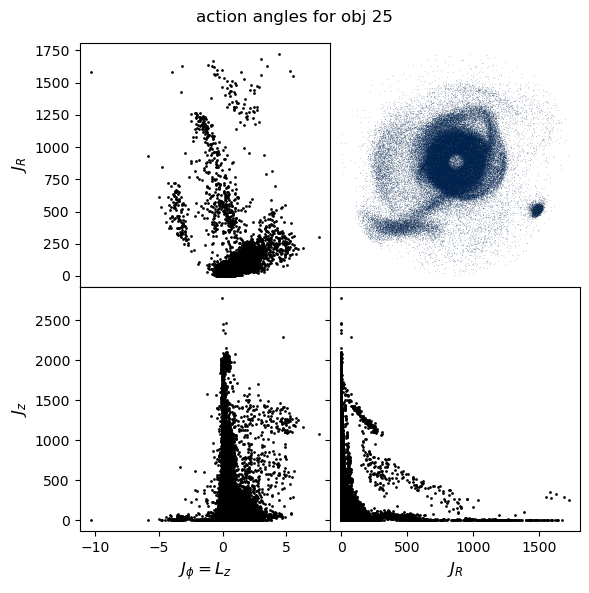

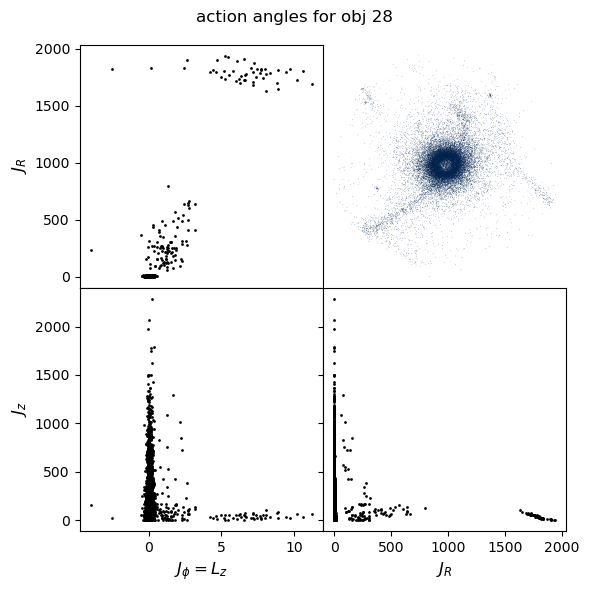

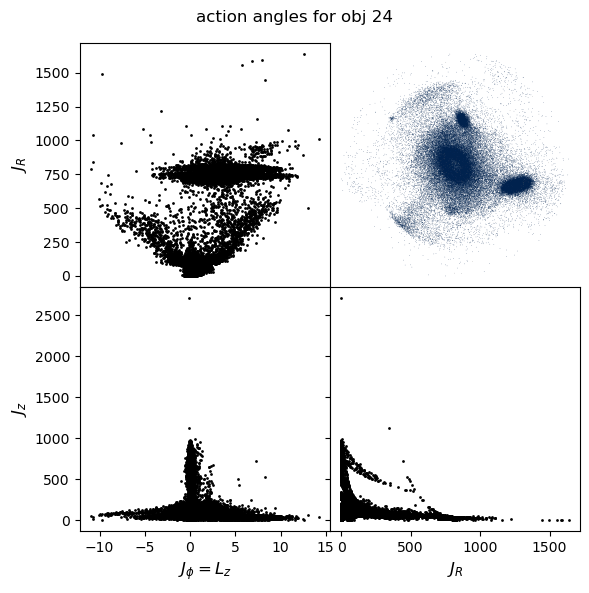

In [9]:
#[jr, jp, jz]

for file in loaded_actions_dict:

    jr = loaded_actions_dict[file][0]
    jp = loaded_actions_dict[file][1]
    jz = loaded_actions_dict[file][2]
    
    fig = plt.figure(figsize=(6,6))
    gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
    # (ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')
    axs = gs.subplots(sharex=False, sharey=False)
    n=1
    size = 4
    alph= 1

    font_size = 12

    axs[0,0].scatter(jp[::n], jr[::n], s=size, linewidths=0, alpha = alph, color = 'black', label = 'radial')
    axs[0,0].set_xlabel('$J_{\phi} = L_z$', fontsize = font_size)
    axs[0,0].set_ylabel('$J_R$', fontsize = font_size)
    # axs[0,0].set_xlim(-12, 12)


    axs[1,0].scatter(jp[::n], jz[::n], s=size, linewidths=0, alpha = alph, color = 'black', label = 'radial')
    axs[1,0].set_xlabel('$J_{\phi} = L_z$', fontsize = font_size)
    axs[1,0].set_ylabel('$J_z$', fontsize = font_size)
    # axs[1,0].set_xlim(-12, 12)
    # axs[1,0].set_ylim(-40, 1200)


    axs[1,1].scatter(jr[::n], jz[::n], s=size, linewidths=0, alpha = alph, color = 'black', label = 'radial')
    axs[1,1].set_xlabel('$J_R$', fontsize = font_size)
    axs[1,1].set_ylabel('$J_z$', fontsize = font_size)
    # axs[1,1].set_ylim(-40, 1200)
    
    alph=0.9
    size=0.15
    axs[0,1].scatter(transformed_pos[file][0][pos_mask[file]][::n], transformed_pos[file][1][pos_mask[file]][::n], s=size, linewidths=0, alpha = alph, c = np.sqrt(abs(jz))[::n], cmap='cividis', label = 'radial')

    
    fig.suptitle('action angles for obj ' + str(file))

    axs[0,1].axis('off')

    for ax in fig.get_axes():
        ax.label_outer()

    plt.tight_layout()

    plt.savefig('./pot_fit_actions_' + str(file)'.jpg', dpi= 300)
    
    plt.show()

<>:99: SyntaxWarning: invalid escape sequence '\p'

<>:105: SyntaxWarning: invalid escape sequence '\p'

<>:99: SyntaxWarning: invalid escape sequence '\p'

<>:105: SyntaxWarning: invalid escape sequence '\p'

/var/folders/cs/cpwlb8215w7_8nfgdjnp7y400000gn/T/ipykernel_5893/72018869.py:99: SyntaxWarning: invalid escape sequence '\p'
  axs[0, 0].set_xlabel('$J_{\phi} = L_z$', fontsize=font_size)

/var/folders/cs/cpwlb8215w7_8nfgdjnp7y400000gn/T/ipykernel_5893/72018869.py:105: SyntaxWarning: invalid escape sequence '\p'
  axs[1, 0].set_xlabel('$J_{\phi} = L_z$', fontsize=font_size)

clustering
Estimated number of clusters: 15
Estimated number of noise points: 1673
/var/folders/cs/cpwlb8215w7_8nfgdjnp7y400000gn/T/ipykernel_5893/72018869.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("

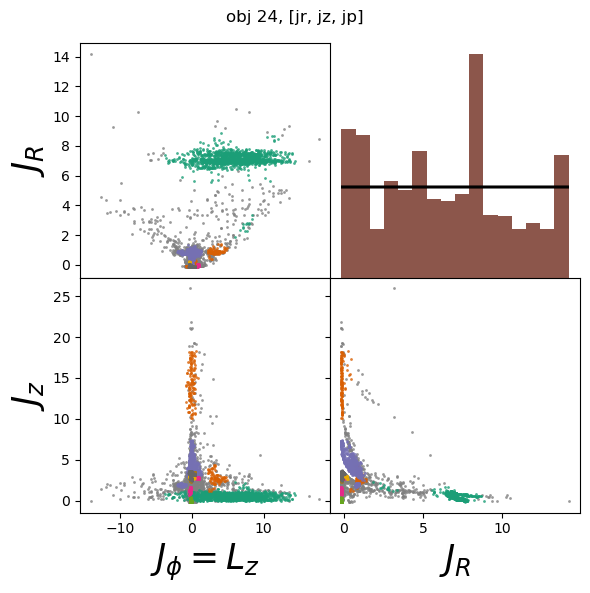

clustering
Estimated number of clusters: 33
Estimated number of noise points: 5741
/var/folders/cs/cpwlb8215w7_8nfgdjnp7y400000gn/T/ipykernel_5893/72018869.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("Dark2", len(unique_labels))



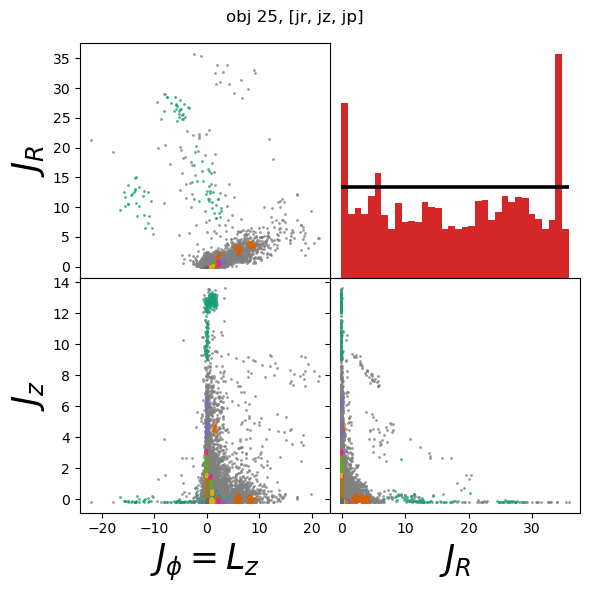

clustering
Estimated number of clusters: 20
Estimated number of noise points: 2564
/var/folders/cs/cpwlb8215w7_8nfgdjnp7y400000gn/T/ipykernel_5893/72018869.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("Dark2", len(unique_labels))



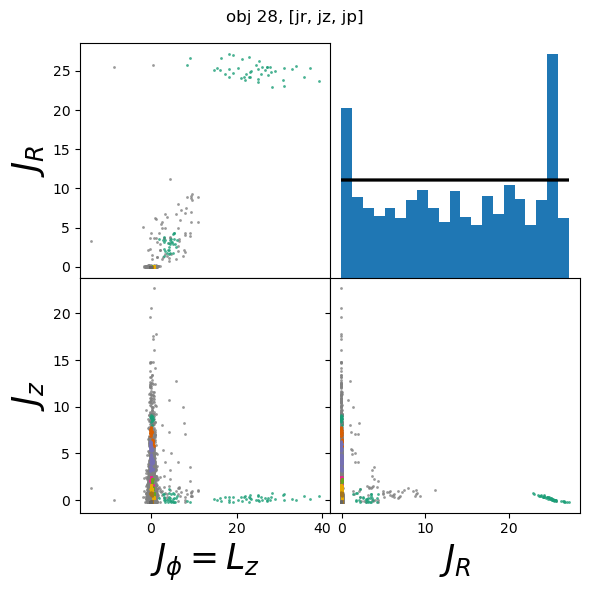

In [ ]:
#clustering

from random import sample

with open('./actions_dict.pkl', 'rb') as f:
    loaded_actions_dict = pickle.load(f)

files = ['24', '25', '28']
n = 10

labels_dict = {}

for file in files:

    actions = np.array(loaded_actions_dict[file]).T
    
    # actions = ((np.array(actions).T)[::n]).T
    # actions = ((np.array(actions).T)[:50_000]).T
    # actions = sample(np.array(actions).T, 50_000)
    # points = np.array(loaded_actions_dict['25']).T
    
    sample_size = min(70_000, actions.shape[0])
    actions = (actions[np.random.choice(actions.shape[0], size=sample_size, replace=False)]).T
    
    # Combine the data into one array and scale it
    # data = np.column_stack((actions, x, y, z, vx, vy, vz))
    
    data = np.column_stack((actions))[sample_size] # !!!! not ideal, temporary 
    scaler = StandardScaler()
    scaler.fit(data)
    transformed_data = scaler.transform(data)
    
    size = 4
    alph = .8
    font_size = 25
    random_state = 10
    
    for min_cluster_size in [13]: #13
        fig = plt.figure(figsize=(6, 6))
        gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
        axs = gs.subplots(sharex=False, sharey=False)

        X = transformed_data

        common_params = {
            "n_init": "auto",
            "random_state": random_state,
        }

        # y_pred = KMeans(n_clusters=int(n_clusters), **common_params).fit_predict(X)
        print('clustering')
        
        hdb = HDBSCAN(min_cluster_size=int(min_cluster_size)).fit(X)
        labels_dict[file] = hdb.labels_
        labels = hdb.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

        # print(i)
        print("Estimated number of clusters: %d" % n_clusters_)
        print("Estimated number of noise points: %d" % n_noise_)
        
        unique_labels = set(labels)

        # Transpose for easy access to columns
        X_T = transformed_data.T

        # List of unique cluster labels
        # unique_labels = np.unique(y_pred)

        # Define colors for each cluster
        colors = plt.cm.get_cmap("Dark2", len(unique_labels))

        # Plot each cluster with a specific color and label
        for label in unique_labels:
            # print('plotting ' + str(label))
            
            cluster_indices = (labels == label)  # Use labels instead of y_pred
            if label == -1:
                # Special handling for noise points
                color = "grey"  # Color for noise points
                label_name = "Noise"
                zorder = -.5
            else:
                color = colors(label / len(unique_labels))  # Normalize label to [0, 1] for colormap
                label_name = f"Cluster {label}"
                zorder = 1
            
            
            # color = colors(label / len(unique_labels))  # Normalize label to [0, 1] for colormap

            # jr/jp
            axs[0, 0].scatter(X_T[1][cluster_indices], X_T[0][cluster_indices], s=size, linewidths=0, 
                            alpha=alph, color=color, label=f' {label}', zorder = zorder)
            axs[0, 0].set_xlabel('$J_{\phi} = L_z$', fontsize=font_size)
            axs[0, 0].set_ylabel('$J_R$', fontsize=font_size)

            # jz/jp
            axs[1, 0].scatter(X_T[1][cluster_indices], X_T[2][cluster_indices], s=size, linewidths=0, 
                            alpha=alph, color=color, label=f' {label}', zorder = zorder)
            axs[1, 0].set_xlabel('$J_{\phi} = L_z$', fontsize=font_size)
            axs[1, 0].set_ylabel('$J_z$', fontsize=font_size)

            # jz/jr
            axs[1, 1].scatter(X_T[0][cluster_indices], X_T[2][cluster_indices], s=size, linewidths=0, 
                            alpha=alph, color=color, label=f' {label}', zorder = zorder)
            axs[1, 1].set_xlabel('$J_R$', fontsize=font_size)
            axs[1, 1].set_ylabel('$J_z$', fontsize=font_size)

            # # y/x
            # axs[0, 1].scatter(x[cluster_indices], y[cluster_indices], s=size, linewidths=0, 
            #                   alpha=alph, color=color, zorder = zorder)
            # axs[0, 1].set_xlabel('$x$', fontsize=font_size)
            # axs[0, 1].set_ylabel('$y$', fontsize=font_size)
        # axs[0, 1].scatter(x[data.T[3] < -3.5], y[data.T[3] < -3.5], s=size/2, linewidths=.35, 
        #                       alpha=1, color=color, label='Z<-3.5', edgecolors = 'black', zorder = zorder)
        
            axs[0, 1].hist(labels, log=True, bins=len(unique_labels))
            axs[0, 1].hlines(100, -1, len(unique_labels) - 2, color='black')

            # axs[0, 1].set_xlabel('stream')
            # axs[0, 1].set_ylabel('count')

        # print(sum(label))
        

        # Remove axis labels on overlapping plots
        axs[0, 1].axis('off')
        # axs[0,1].legend(loc='lower right')
        # axs[1,1].legend(loc='upper right')

        # Add legends to all subplots
        for ax in fig.get_axes():
            ax.label_outer()
            # ax.legend(loc='upper right')
            
        fig.suptitle('obj ' + file + ', [jr, jz, jp]')

        plt.tight_layout()

        # Show the figure
        plt.show()
        
#50k = 1:15
#70k = 1:58

In [35]:
#chemical check

unique_dict = {}
for file in files:
    unique_dict[file] = set(labels_dict[file])
    
unique_dict['24']

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

In [ ]:
files={}
for filepath in glob.iglob('./objects/*'):
    files[filepath[len(filepath)-7:][:-5]]=h5py.File(filepath)
    print(filepath)
files

metal00_dict = {}
file_names = ['24', '28', '25']

sample_size = 70_000
              
for name in file_names:
    metal00_dict[name] = files[name]['stellar_metal_00'][::n][:sample_size]

#fucked it up because: the filtering done in the action angle finding AND in the clustering (down sampling)
# has unlinked the star particle array index from the actual ID, so i dont know how to get the corresponding metallicity etc
# from the file

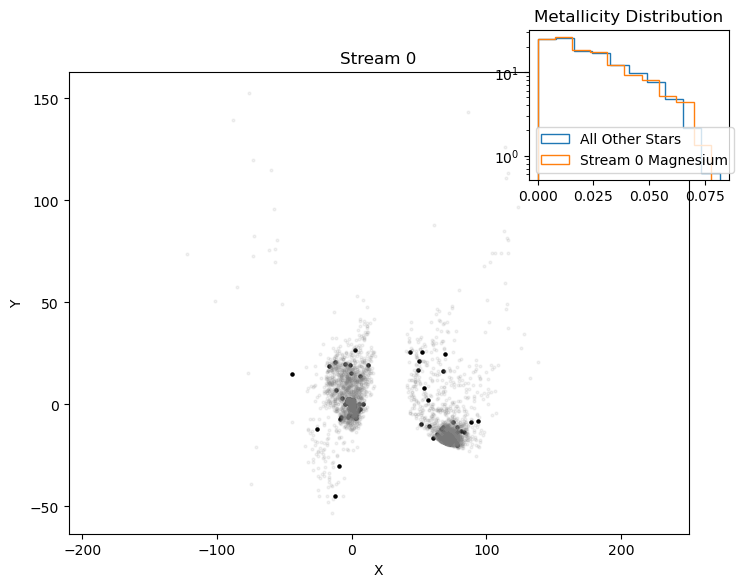

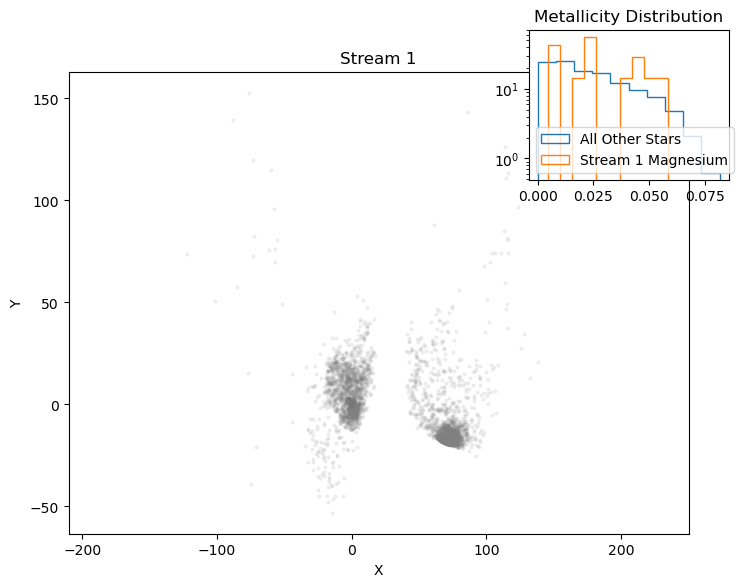

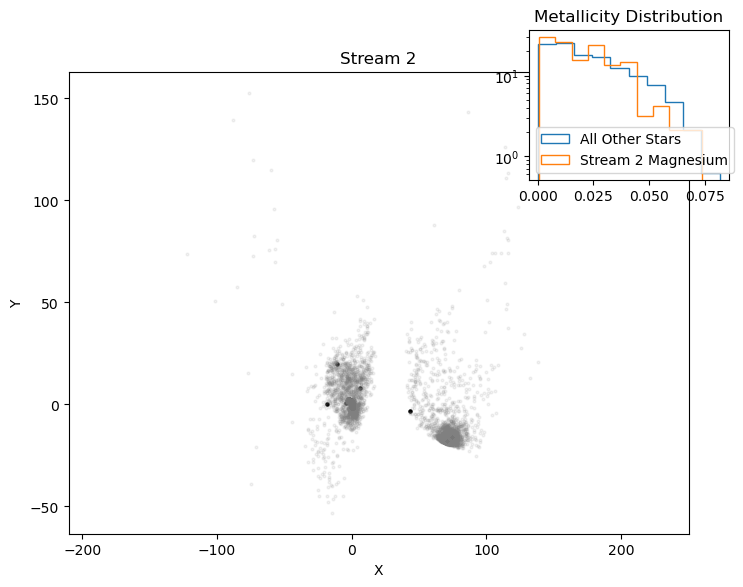

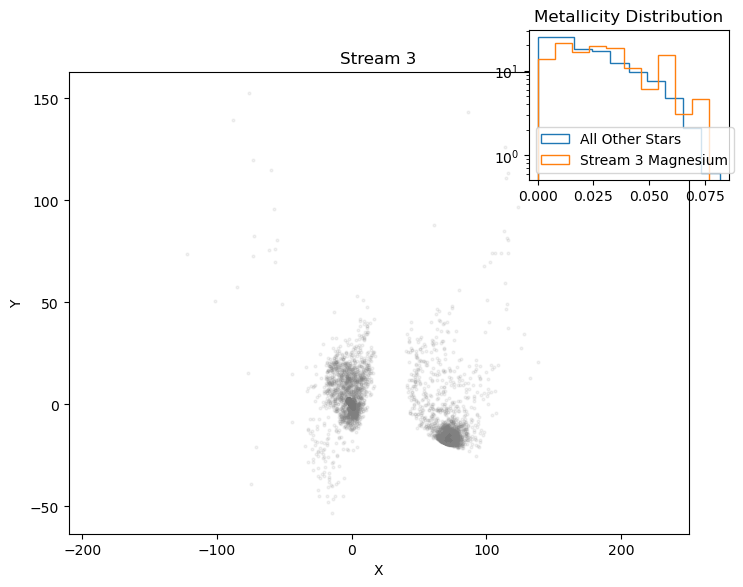

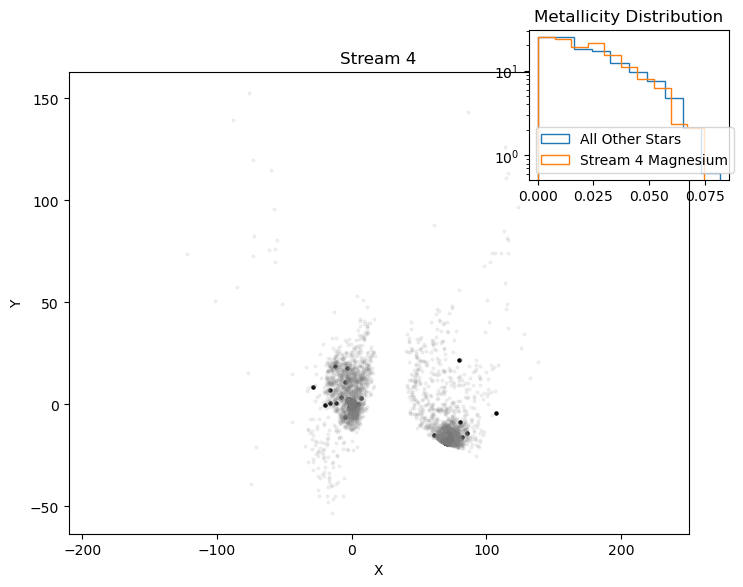

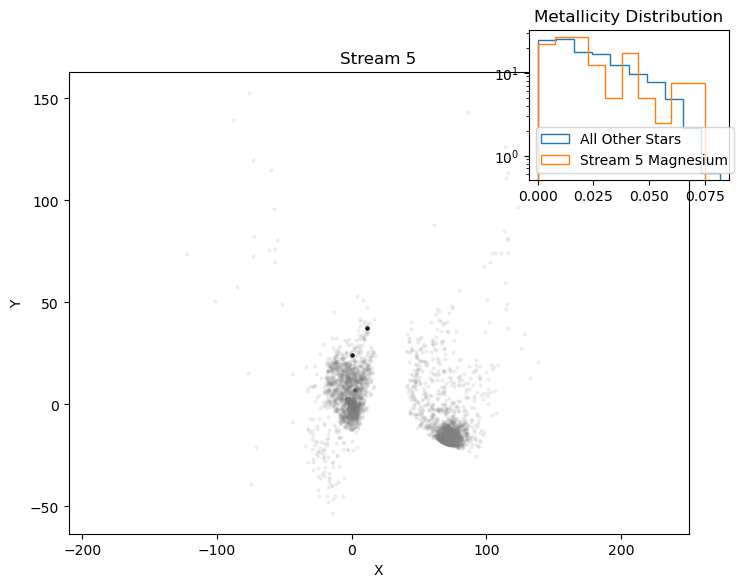

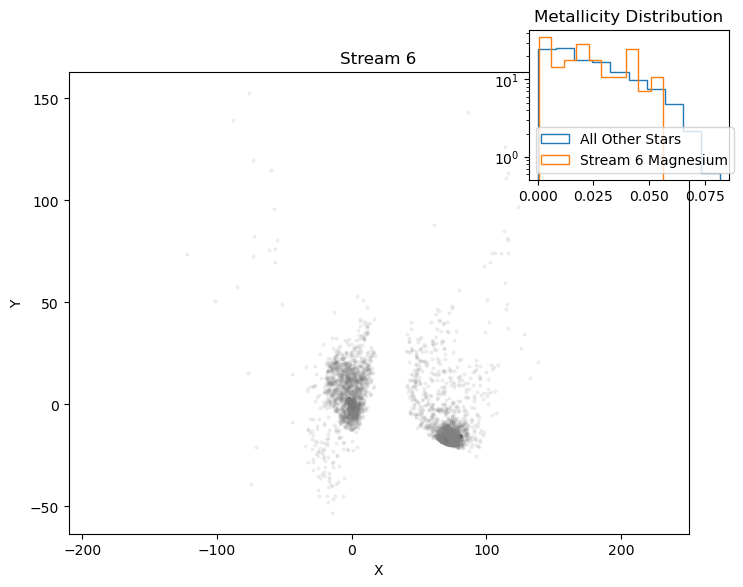

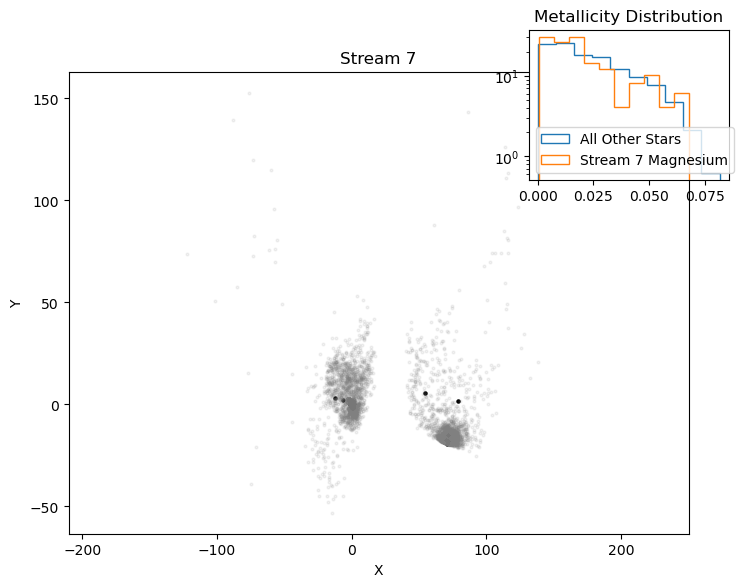

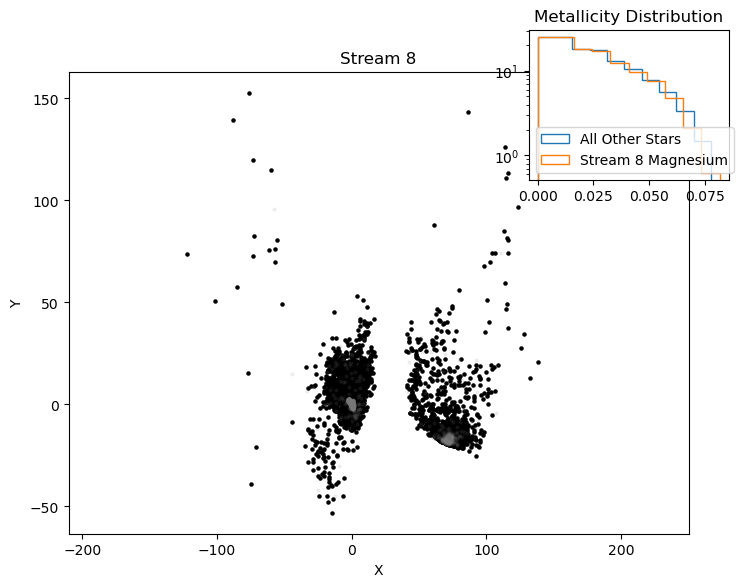

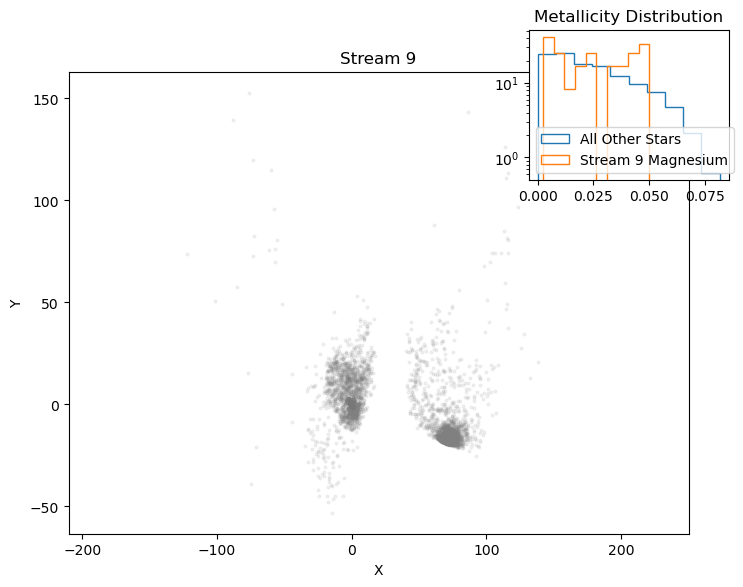

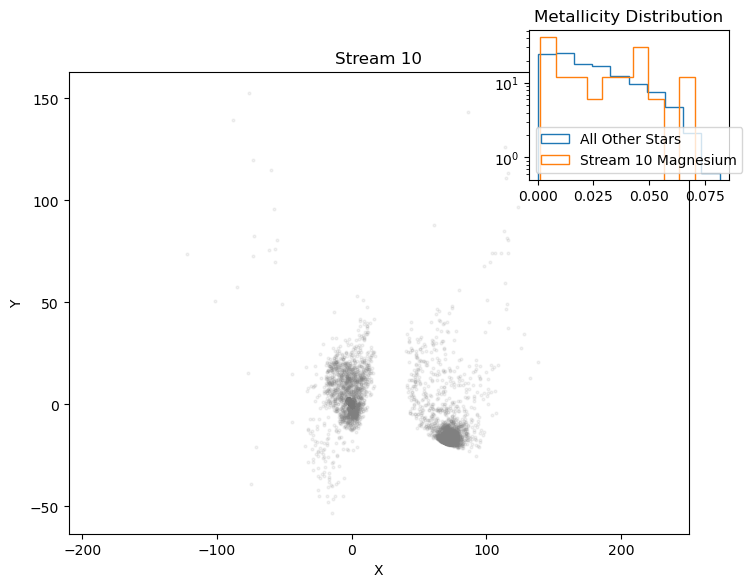

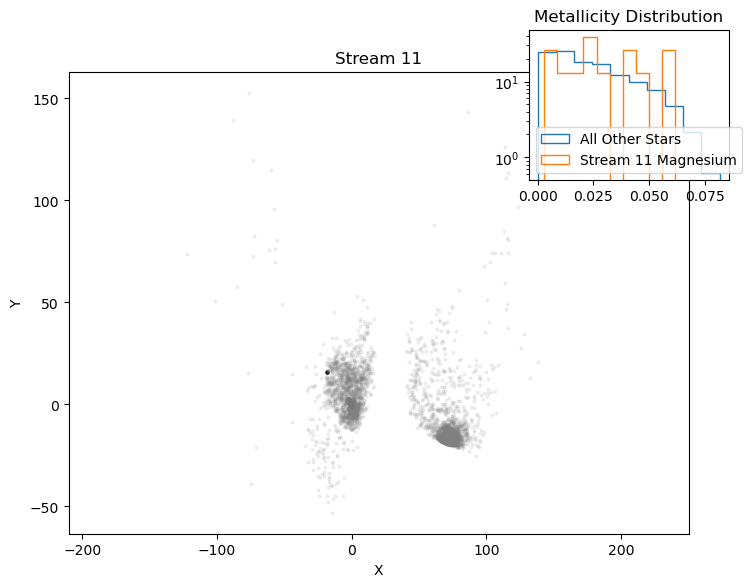

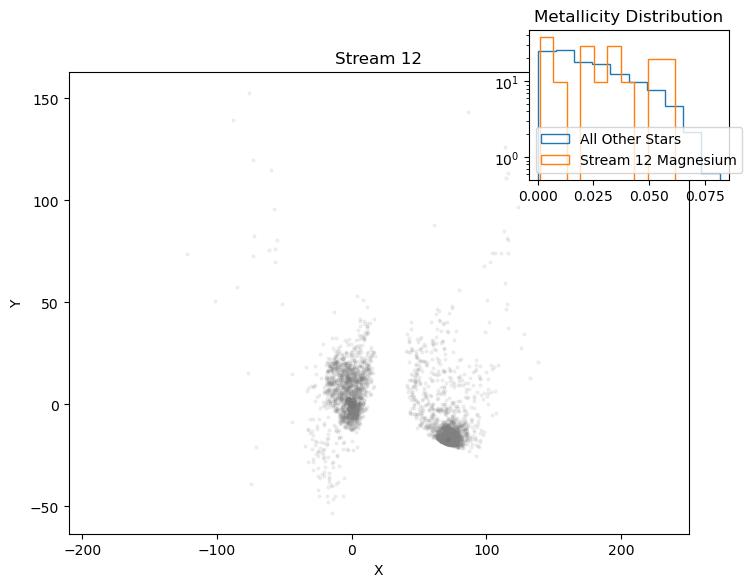

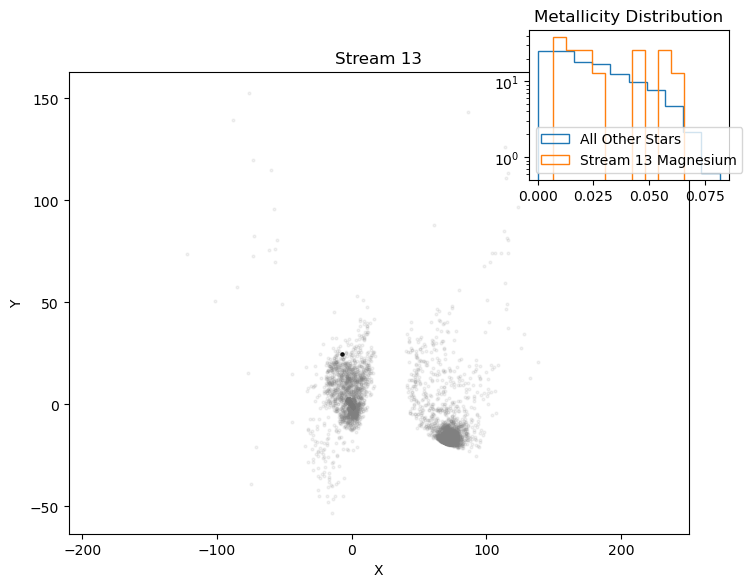

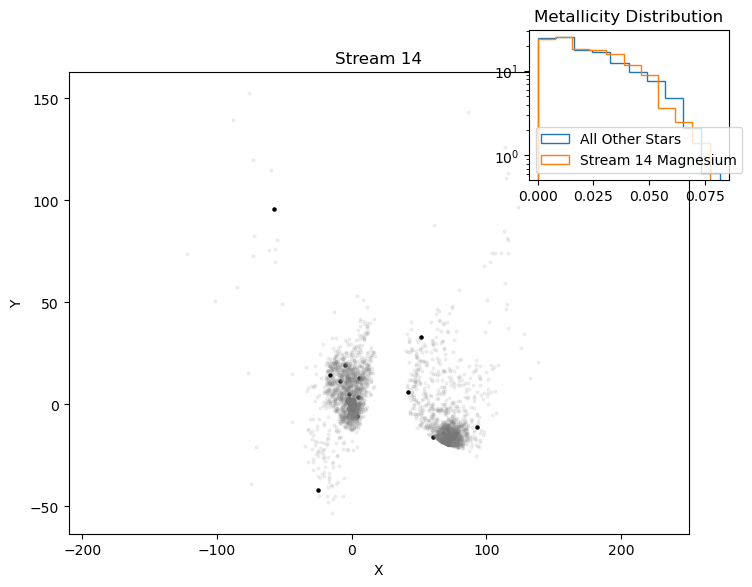

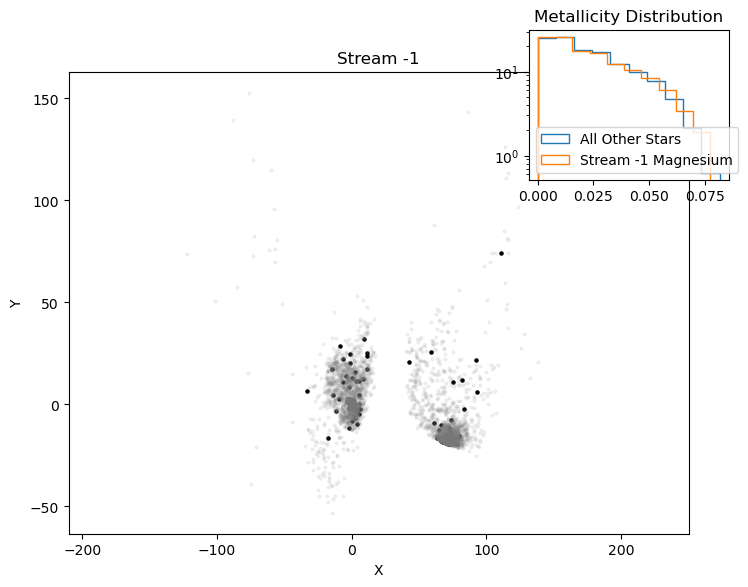

In [ ]:
unique_labels = unique_dict['24']
labels = labels_dict['24']

for file in ['24']:
    x=transformed_pos[file][0]
    y=transformed_pos[file][1]
    z=transformed_pos[file][2]
    
    x=x[:70_000]
    y=y[:70_000]
    z=z[:70_000]

for i in unique_labels:
    fig = plt.figure(figsize=(8, 6))

    # Scatter plot
    plt.scatter(x[labels == i], y[labels == i], s=5, c='black', label=f'Label {i}')
    plt.scatter(x[labels != i], y[labels != i], c='grey', alpha=0.1, s=3.9, label='Other Labels')
    plt.title(f'Stream {i}')
    plt.xlabel('X')
    plt.ylabel('Y')
    
    plt.xlim(-210, 250)

    inset_ax = fig.add_axes([0.7, 0.7, 0.25, 0.25])  # Adjust these values as needed
    # inset_ax.hist(
    #     f['stars_total_metallicity'][mask][labels != i],
    #     histtype='step',
    #     log=True,
    #     density=True,
    #     label='All Other Stars'
    # )
    
    inset_ax.hist(
        metal00_dict['24'][labels != i],
        histtype='step',
        log=True,
        density=True,
        label='All Other Stars'
    )
    # inset_ax.hist(
    #     f['stars_total_metallicity'][mask][labels == i],
    #     histtype='step',
    #     log=True,
    #     density=True,
    #     label=f'Stream {i}'
    # )
    
    inset_ax.hist(
        metal00_dict['24'][labels == i],
        histtype='step',
        log=True,
        density=True,
        label=f'Stream {i} Magnesium'
    )
    
    inset_ax.set_title('Metallicity Distribution')
    inset_ax.legend(fontsize=8)

    # Showing the plot
    plt.legend()
    plt.show()


In [71]:
files={}
for filepath in glob.iglob('./objects/*'):
    files[filepath[len(filepath)-7:][:-5]]=h5py.File(filepath)
    print(filepath)
files

metal00_dict = {}
file_names = ['24', '28', '25']

sample_size = 70_000
              
for name in file_names:
    metal00_dict[name] = files[name]['stellar_metal_00'][::n][:sample_size]

#fucked it up because: the filtering done in the action angle finding AND in the clustering (down sampling)
# has unlinked the star particle array index from the actual ID, so i dont know how to get the corresponding metallicity etc
# from the file

./objects/particles_within_Rvir_object_25.hdf5
./objects/particles_within_Rvir_object_28.hdf5
./objects/particles_within_Rvir_object_24.hdf5
